In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, cohen_kappa_score, classification_report , roc_curve, roc_auc_score, average_precision_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
# set matplotlib defaults
%matplotlib inline
sns.set()
plt.rcParams["figure.figsize"] = (15,6)
mpl.rc('axes', labelsize=18)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
plt.rc('figure', titlesize=18)
plt.style.use('seaborn-darkgrid')

In [11]:
data_2018 = pd.read_csv("../data/dataset_2018_with_negatives.csv")
data_2019 = pd.read_csv("../data/dataset_2019_with_negatives.csv")

In [12]:
data_2018 = data_2018[(data_2018.summary.notnull())  & (data_2018.month > 8)]

In [13]:
print(data_2019.shape, data_2018.shape)

(58133, 40) (21496, 40)


In [14]:
data = pd.concat([data_2018, data_2019])

In [15]:
# data = pd.get_dummies(data, columns=['summary'])

In [16]:
data.drop(['year', 'precipAccumulation', 'timestamp', 'date', 'address', 
           'severity', 'accident_type','severity_numeric','borough_id',
          'timestamp_darksky', 'summary', 'icon','precipType'], axis=1, inplace=True)

In [17]:
data.reset_index(drop=True, inplace=True)
data.index

RangeIndex(start=0, stop=79629, step=1)

In [18]:
data.columns

Index(['x', 'y', 'month', 'day', 'day_of_year', 'day_of_week', 'hour',
       'borough', 'cluster_id', 'sample_type', 'area_km2', 'population',
       'population_density', 'precipIntensity', 'precipProbability',
       'temperature', 'apparentTemperature', 'dewPoint', 'humidity',
       'windSpeed', 'cloudCover', 'uvIndex', 'visibility', 'windBearing',
       'windGust', 'pressure', 'ozone'],
      dtype='object')

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79629 entries, 0 to 79628
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   x                    79629 non-null  float64
 1   y                    79629 non-null  float64
 2   month                79629 non-null  int64  
 3   day                  79629 non-null  int64  
 4   day_of_year          79629 non-null  int64  
 5   day_of_week          79629 non-null  int64  
 6   hour                 79629 non-null  int64  
 7   borough              79629 non-null  object 
 8   cluster_id           79629 non-null  int64  
 9   sample_type          79629 non-null  int64  
 10  area_km2             79629 non-null  float64
 11  population           79629 non-null  int64  
 12  population_density   79629 non-null  float64
 13  precipIntensity      79629 non-null  float64
 14  precipProbability    79629 non-null  float64
 15  temperature          79629 non-null 

In [20]:
corr = data.corr()
c1 = corr.abs().unstack().round(3)
c1<1
c1[(c1<1) & (c1> 0.65)].sort_values(ascending = False)

month                day_of_year            0.997
apparentTemperature  temperature            0.997
day_of_year          month                  0.997
temperature          apparentTemperature    0.997
                     uvIndex                0.833
uvIndex              temperature            0.833
windSpeed            windGust               0.826
windGust             windSpeed              0.826
apparentTemperature  uvIndex                0.824
uvIndex              apparentTemperature    0.824
precipProbability    precipIntensity        0.802
precipIntensity      precipProbability      0.802
temperature          hour                   0.692
hour                 temperature            0.692
apparentTemperature  hour                   0.685
hour                 apparentTemperature    0.685
apparentTemperature  dewPoint               0.654
dewPoint             apparentTemperature    0.654
dtype: float64

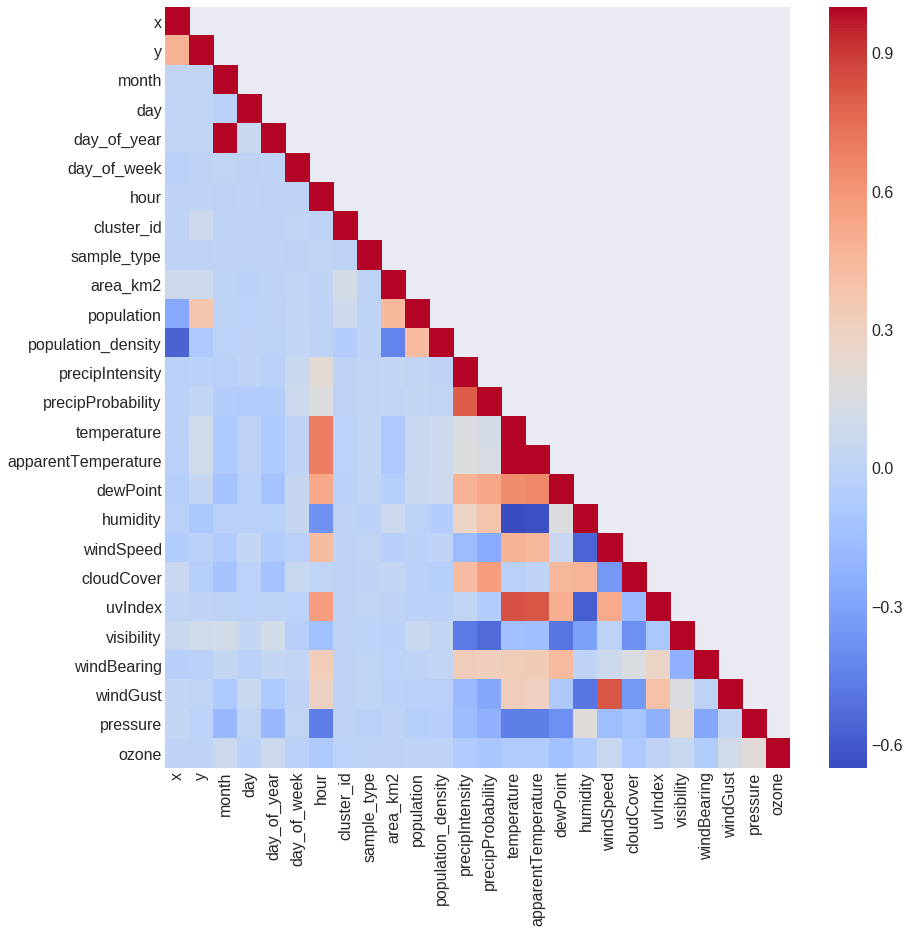

In [21]:
plt.figure(figsize=(14,14))
sns.heatmap(corr.where(np.tril(np.ones(corr.shape)).astype(np.bool)), cmap='coolwarm')
plt.show()

## Useful Functions

In [22]:
def model_fit_predict(X_train, X_test, y_train, y_test, clf):
    categories = ['non-accident', 'accident']
    clf.fit(X_train, y_train)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring= 'roc_auc', n_jobs=-1)
    print('ROC AUC: {:.2f} (+/- {:.3f} )'.format(scores.mean(), scores.std() * 2))

    y_pred = clf.predict(X_test)
    print('Cohen kappa score {:.4f}'.format(cohen_kappa_score(y_pred, y_test)))
    print('F1 score {:.4f}'.format(f1_score(y_pred, y_test,)))
    print('Average precision score {:.4f}'.format(average_precision_score(y_pred, y_test)))
    print(classification_report(y_test, y_pred,target_names=categories))

#     metric_names = ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']
#     scores_df = pd.DataFrame(index=metric_names, columns=['Random-CV', 'Stratified-CV']) # to store the scores
#     cv = KFold(n_splits=3)
#     scv = StratifiedKFold(n_splits=3)
#     for metric in metric_names:
#         score1 = cross_val_score(clf, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1).mean()
#         score2 = cross_val_score(clf, X_train, y_train, scoring=metric, cv=scv, n_jobs=-1).mean()
#         scores_df.loc[metric] = [score1, score2]
#     print(scores_df)
    y_pred_proba = clf.predict_proba(X_test)[:,1]

    return clf, y_pred, y_pred_proba


In [23]:
def model_plot(y_test, y_pred, y_pred_proba, model_name):
    categories = ['non-accident', 'accident']
    gs = mpl.gridspec.GridSpec(2, 2)

    plt.figure(figsize=(14,10))
    ax = plt.subplot(gs[0, 0]) # row 0, col 0
    labels = [0,1]
    cnf_mx = confusion_matrix(y_test,y_pred,labels=labels)
    ax1 = sns.heatmap(cnf_mx, cmap='Blues',annot=True, fmt="d")
    plt.xticks([0.5,1.5],categories, rotation=0)
    plt.yticks([0.5,1.5],categories, rotation=0)
    plt.title(f'Confusion matrix {model_name}', fontsize=18)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    ax = plt.subplot(gs[0, 1]) # row 0, col 1
    row_sums = cnf_mx.sum(axis=1, keepdims=True)
    norm_cnf_mx = cnf_mx / row_sums
    np.fill_diagonal(norm_cnf_mx, 0)
    ax2 = sns.heatmap(norm_cnf_mx, cmap='Blues',annot=True, fmt=".4%")
    plt.xticks([0.5,1.5],categories, rotation=0)
    plt.yticks([0.5,1.5],categories, rotation=0)
    plt.title(f'Error matrix {model_name}', fontsize=18)
    plt.xlabel('Predicted label')

    ax = plt.subplot(gs[1, :]) # row 1, span all columns
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    # Display plot for AUC curve
    ax3 = plt.plot(fpr,tpr,label= f"{model_name}, auc={round(auc,4)}")
    ax3 = plt.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--')
    plt.legend(fontsize=14)
    plt.title(f"ROC cuve: {model_name}", fontsize= 18)
    plt.tight_layout()
    plt.show()

In [24]:
def generate_cyclical_variables(df, column, period):
    if df[column].min() != 0:
        df[f'{column}_sin'] = np.sin((df[column] - 1)*(2.*np.pi/period))
        df[f'{column}_cos'] = np.cos((df[column] - 1)*(2.*np.pi/period))
    else:
        df[f'{column}_sin'] = np.sin((df[column])*(2.*np.pi/period))
        df[f'{column}_cos'] = np.cos((df[column])*(2.*np.pi/period))

    return df

In [28]:
def generate_precipitation_intensity(df, column_intensity, column_probability):
    df['precip_intensity_probability'] = df.precipIntensity * df.precipProbability
    return df

In [33]:
data = (data.pipe(generate_precipitation_intensity, column_intensity='precipIntensity', column_probability = 'precipProbability' )
 .pipe(generate_cyclical_variables, column='hour', period = 24)
 .pipe(generate_cyclical_variables, column='day_of_week', period = 7)
 .pipe(generate_cyclical_variables, column='month', period = 12)
 .pipe(generate_cyclical_variables, column='day_of_year', period = 365)
)

In [37]:
#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self._feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self._feature_names ] 

NameError: name 'BaseEstimator' is not defined

In [36]:
pipeline = Pipeline([
    ("precip_intensirt", DataframeFunctionTransformer(data, column_intensity='precipIntensity', column_probability = 'precipProbability'))
])

# apply the pipeline to the input dataframe
pipeline.fit_transform(df)

TypeError: __init__() got an unexpected keyword argument 'column_intensity'

In [22]:
data.columns

Index(['x', 'y', 'timestamp', 'date', 'month', 'day', 'day_of_year',
       'day_of_week', 'hour', 'address', 'severity', 'accident_type',
       'severity_numeric', 'borough', 'cluster_id', 'sample_type',
       'borough_id', 'area_km2', 'population', 'population_density',
       'timestamp_darksky', 'icon', 'precipIntensity', 'precipProbability',
       'temperature', 'apparentTemperature', 'dewPoint', 'humidity',
       'windSpeed', 'cloudCover', 'uvIndex', 'visibility', 'windBearing',
       'windGust', 'pressure', 'precipType', 'ozone', 'summary_Clear',
       'summary_Foggy', 'summary_Heavy Rain', 'summary_Light Rain',
       'summary_Mostly Cloudy', 'summary_Overcast', 'summary_Partly Cloudy',
       'summary_Possible Drizzle', 'summary_Possible Light Rain',
       'summary_Rain', 'hour_sin', 'hour_cos', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_year_sin',
       'day_of_year_cos', 'precip_intensity_probability'],
      dtype='object')

In [23]:
cols_to_keep = ['x', 'y', 'cluster_id', 'sample_type',
       'area_km2', 'population', 'population_density',
       'precipIntensity', 'precipProbability', 'temperature',
       'apparentTemperature', 'dewPoint', 'humidity', 'windSpeed',
       'cloudCover', 'uvIndex', 'visibility',
       'pressure', 'ozone', 'summary_Clear', 'summary_Foggy',
       'summary_Heavy Rain', 'summary_Light Rain', 'summary_Mostly Cloudy',
       'summary_Overcast', 'summary_Partly Cloudy', 'summary_Possible Drizzle',
       'summary_Possible Light Rain', 'summary_Rain', 'hour_sin', 'hour_cos',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'day_of_year_sin', 'day_of_year_cos', 'precip_intensity_probability']
data = data[cols_to_keep]

In [24]:
numeric_features = ['x', 'y', 'population_density',
       'precip_intensity_probability', 'temperature',
       'dewPoint', 'humidity', 'windSpeed',
       'cloudCover', 'uvIndex', 'visibility',
       'pressure', 'ozone','hour_sin', 'hour_cos',
       'day_of_week_sin', 'day_of_week_cos', 
       'month_sin', 'month_cos',
       'day_of_year_sin', 'day_of_year_cos']

# categorical_features = ['cluster_id']

ohe_weather_features = ['summary_Clear', 'summary_Foggy',
       'summary_Heavy Rain', 'summary_Light Rain', 'summary_Mostly Cloudy',
       'summary_Overcast', 'summary_Partly Cloudy', 'summary_Possible Drizzle',
       'summary_Possible Light Rain', 'summary_Rain']
       
# ohe_borough_features = ['borough_ANTONIO NARIÑO',
#        'borough_BARRIOS UNIDOS', 'borough_BOSA', 'borough_CANDELARIA',
#        'borough_CHAPINERO', 'borough_CIUDAD BOLIVAR', 'borough_ENGATIVA',
#        'borough_FONTIBON', 'borough_KENNEDY', 'borough_LOS MARTIRES',
#        'borough_PUENTE ARANDA', 'borough_RAFAEL URIBE URIBE',
#        'borough_SAN CRISTOBAL', 'borough_SANTA FE', 'borough_SUBA',
#        'borough_SUMAPAZ', 'borough_TEUSAQUILLO', 'borough_TUNJUELITO',
#        'borough_USAQUEN', 'borough_USME']

target_feature = ['sample_type']

## Numeric feature scaling

In [25]:
data_numeric = data[numeric_features]
data_numeric.head(2)

,x,y,population_density,precip_intensity_probability,temperature,dewPoint,humidity,windSpeed,cloudCover,uvIndex,...,pressure,ozone,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_year_sin,day_of_year_cos
0,-74.154268,4.622942,28205.31,0.087780,14.62,12.92,0.90,1.48,0.74,5.0,...,1015.4,268.4,-0.500000,-0.866025,-0.433884,-0.900969,-0.866025,-0.5,-0.953681,-0.300820
1,-74.051403,4.722273,12117.27,0.016709,19.41,12.60,0.65,2.33,0.71,8.0,...,1013.1,266.2,-0.707107,-0.707107,-0.974928,-0.222521,-0.866025,-0.5,-0.998880,-0.047321


In [26]:
scaled_features = StandardScaler().fit_transform(data_numeric.values)
scaled_features_df = pd.DataFrame(scaled_features, index=data_numeric.index, columns=data_numeric.columns)
scaled_features_df

,x,y,population_density,precip_intensity_probability,temperature,dewPoint,humidity,windSpeed,cloudCover,uvIndex,...,pressure,ozone,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_year_sin,day_of_year_cos
0,-1.303188,-0.472485,1.481885,-0.332505,0.266373,0.976048,0.656771,-0.679009,-0.409249,0.690870,...,-0.236849,1.756544,-0.560156,-0.935940,-0.665850,-1.203199,-0.923700,-0.802728,-1.082102,-0.571543
1,1.291098,1.310883,-0.420427,-0.530094,1.803363,0.839213,-1.476156,0.473268,-0.586550,1.639217,...,-1.164030,1.520226,-0.845133,-0.677922,-1.434435,-0.244487,-0.923700,-0.802728,-1.145696,-0.195190
2,0.195069,-1.417821,-0.878419,-0.301412,-1.517691,-0.708728,1.424624,-0.923020,-0.054646,-0.889708,...,0.166273,1.702835,0.815833,-0.935940,1.335447,-0.244487,-1.110443,-0.051325,-1.146946,-0.092991
3,0.343510,1.279385,-0.420427,-0.574231,-0.487683,0.253390,0.912722,-0.909464,0.772759,-0.573593,...,0.287210,1.509484,0.483970,-1.098137,0.566863,-1.203199,-1.110443,-0.051325,-1.146217,-0.067447
4,0.746928,0.710758,-0.420427,-0.574231,-0.487683,0.253390,0.912722,-0.909464,0.772759,-0.573593,...,0.287210,1.509484,0.483970,-1.098137,0.566863,-1.203199,-1.110443,-0.051325,-1.146217,-0.067447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79624,-0.834559,-1.229071,0.526333,-0.361294,1.723144,-0.020279,-2.073375,0.066582,-1.000253,1.955333,...,-0.559347,-1.197429,-1.063803,-0.341665,1.061143,0.951008,-0.413508,1.250143,-0.413862,1.178515
79625,0.462069,-1.057263,-1.565142,1.716517,-0.850271,-0.336709,0.827405,-1.275482,0.713659,-0.889708,...,0.609708,-1.444489,1.319480,1.281923,-1.434435,-0.244487,0.283427,1.451481,0.524538,1.333163
79626,0.122174,-0.532760,-0.088873,-0.272087,1.081395,0.706655,-0.793619,0.324150,-0.054646,1.639217,...,0.166273,0.768305,-1.063803,-0.341665,-0.665850,-1.203199,-1.110443,-0.051325,-1.146217,-0.067447
79627,-1.806306,-1.310916,-1.209638,0.671935,0.757311,1.412208,0.400819,0.256369,0.359056,1.006986,...,-1.526840,-2.067508,-1.201265,0.890344,-0.665850,-1.203199,-0.413508,1.250143,-0.028871,1.328137


In [27]:
scaled_features1 = MinMaxScaler(feature_range=(-1,1)).fit_transform(data_numeric.values)
scaled_features_df_1 = pd.DataFrame(scaled_features1, index=data_numeric.index, columns=data_numeric.columns)
scaled_features_df_1

,x,y,population_density,precip_intensity_probability,temperature,dewPoint,humidity,windSpeed,cloudCover,uvIndex,...,pressure,ozone,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_of_year_sin,day_of_year_cos
0,0.189165,0.526393,1.000000,-0.982737,0.120037,0.503178,0.710145,-0.678019,0.469388,-0.285714,...,0.093750,0.618519,-0.500000,-0.866025,-0.445042,-1.000000,-0.866025,-5.000000e-01,-0.953690,-0.300844
1,0.772001,0.764204,-0.141119,-0.996714,0.567492,0.469280,-0.014493,-0.414861,0.408163,0.142857,...,-0.145833,0.537037,-0.707107,-0.707107,-1.000000,-0.286208,-0.866025,-5.000000e-01,-0.998889,-0.047341
2,0.525765,0.400333,-0.415850,-0.980537,-0.399346,0.085805,0.971014,-0.733746,0.591837,-1.000000,...,0.197917,0.600000,0.500000,-0.866025,1.000000,-0.286208,-1.000000,-1.836970e-16,-0.999778,0.021498
3,0.559114,0.760004,-0.141119,-0.999836,-0.099486,0.324153,0.797101,-0.730650,0.877551,-0.857143,...,0.229167,0.533333,0.258819,-0.965926,0.445042,-1.000000,-1.000000,-1.836970e-16,-0.999259,0.038704
4,0.649747,0.684178,-0.141119,-0.999836,-0.099486,0.324153,0.797101,-0.730650,0.877551,-0.857143,...,0.229167,0.533333,0.258819,-0.965926,0.445042,-1.000000,-1.000000,-1.836970e-16,-0.999259,0.038704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79624,0.294448,0.425503,0.426803,-0.984773,0.544138,0.256356,-0.217391,-0.507740,0.265306,0.285714,...,0.010417,-0.400000,-0.866025,-0.500000,0.801938,0.603875,-0.500000,8.660254e-01,-0.478738,0.877958
79625,0.585750,0.448413,-0.827787,-0.837789,-0.205044,0.177966,0.768116,-0.814241,0.857143,-1.000000,...,0.312500,-0.485185,0.866025,0.500000,-1.000000,-0.286208,0.000000,1.000000e+00,0.188228,0.982125
79626,0.509389,0.518355,0.057766,-0.978463,0.357310,0.436441,0.217391,-0.448916,0.591837,0.142857,...,0.197917,0.277778,-0.866025,-0.500000,-0.445042,-1.000000,-1.000000,-1.836970e-16,-0.999259,0.038704
79627,0.076133,0.414589,-0.614535,-0.911683,0.262961,0.611229,0.623188,-0.464396,0.734694,-0.142857,...,-0.239583,-0.700000,-0.965926,0.258819,-0.445042,-1.000000,-0.500000,8.660254e-01,-0.205106,0.978740


## Model 1

### Numeric variables

In [43]:
scaled_features_ohe_weather_df = scaled_features_df_1.join(data[ohe_weather_features])

In [29]:
scaled_features_ohe_weather_df.shape

(79629, 31)

In [44]:
X_train_3, X_test_val_3, y_train_3, y_test_val_3 = train_test_split(scaled_features_df_1, data[target_feature], test_size=0.33, random_state = 42)
X_test_3, X_val_3, y_test_3, y_val_3 = train_test_split(X_test_val_3, y_test_val_3, test_size=0.33, random_state = 42)


In [65]:
%%time
clf = RandomForestClassifier(n_estimators=150, max_leaf_nodes=50, min_samples_leaf=200, max_features=10, n_jobs=-1, criterion='entropy')

clf3, y_pred_3, y_pred_proba_3 = model_fit_predict(X_train_3, X_val_3, y_train_3.values.ravel(), y_val_3.values.ravel(), clf)

ROC AUC: 0.64 (+/- 0.012 )
Cohen kappa score 0.1924
F1 score 0.5250
Average precision score 0.4132
              precision    recall  f1-score   support

non-accident       0.58      0.74      0.65      4369
    accident       0.63      0.45      0.53      4303

    accuracy                           0.60      8672
   macro avg       0.61      0.60      0.59      8672
weighted avg       0.60      0.60      0.59      8672

CPU times: user 45 s, sys: 125 ms, total: 45.1 s
Wall time: 1min 10s


In [62]:
rf_feature_importance = pd.DataFrame(clf3.feature_importances_,
                                   index = scaled_features_df_1.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)

In [63]:
rf_feature_importance

,importance
uvIndex,0.371217
hour_sin,0.204732
hour_cos,0.194446
temperature,0.059410
visibility,0.036465
cloudCover,0.025944
pressure,0.020085
windSpeed,0.018712
precip_intensity_probability,0.011540
dewPoint,0.008789


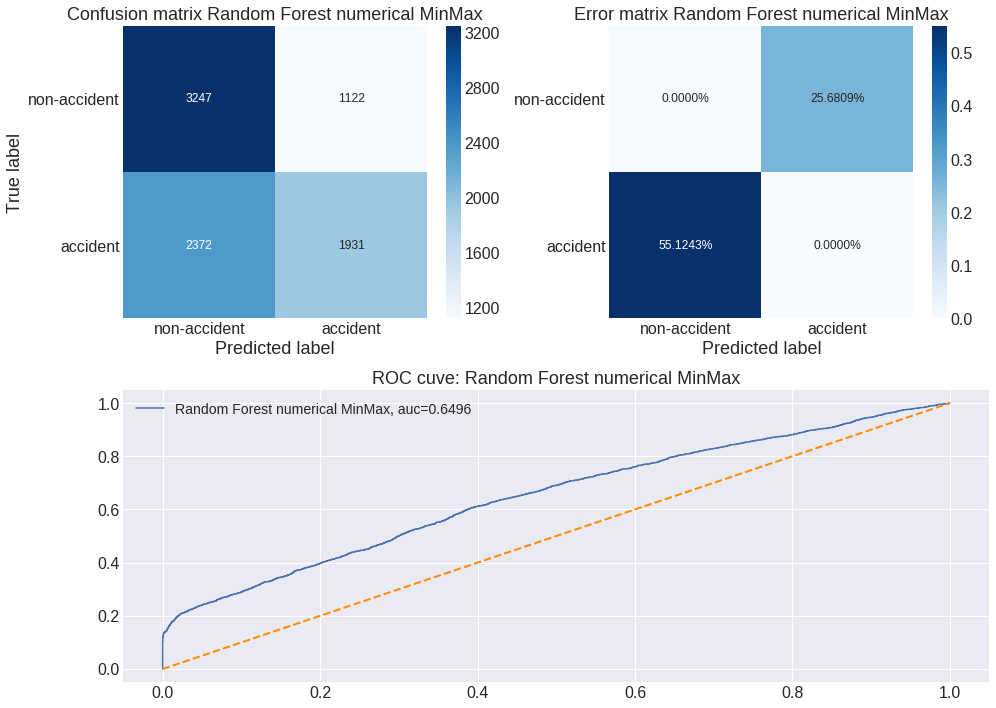

In [66]:
model_plot(y_val_3, y_pred_3, y_pred_proba_3, 'Random Forest numerical MinMax')

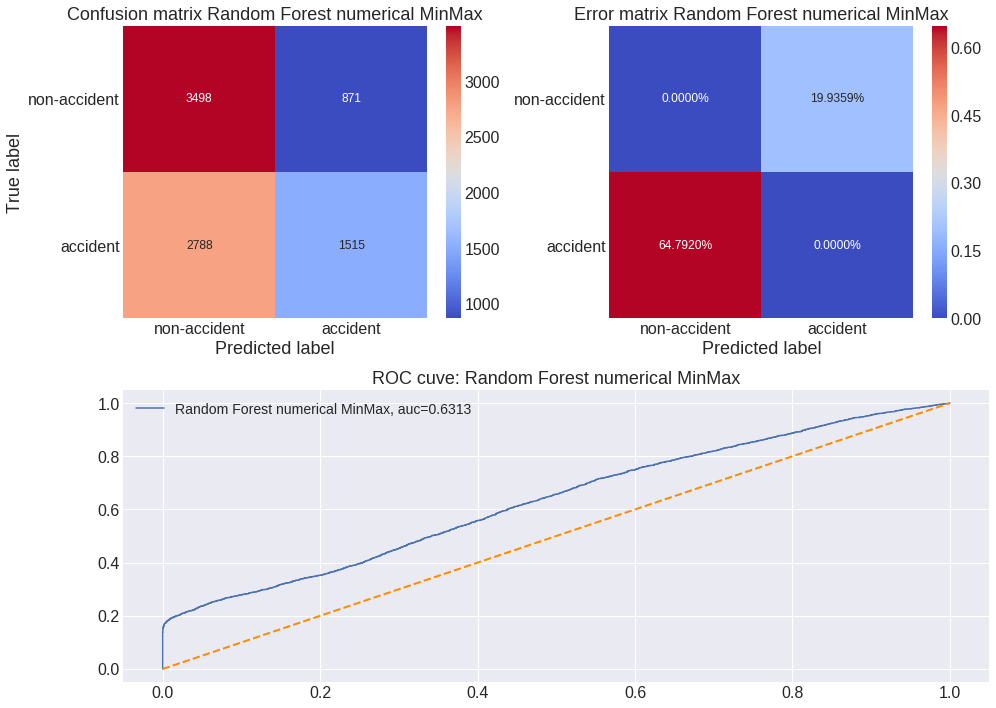

In [77]:
model_plot(y_val_3, y_pred_3, y_pred_proba_3, 'Random Forest numerical MinMax')